In [7]:
# Install necessary libraries if needed
!pip install -q seaborn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

# For handling class imbalance
from imblearn.over_sampling import SMOTE

# Load dataset from files tab
df = pd.read_csv("f1_pitstops_2018_2024.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(r"[^\w_]", "", regex=True)

# Convert and clean numeric columns
df["pit_time"] = pd.to_numeric(df["pit_time"], errors="coerce")
df["position"] = pd.to_numeric(df["position"], errors="coerce")
df = df.dropna(subset=["season", "driver", "position", "laps"])
df.head()

,season,round,circuit,driver,constructor,laps,position,totalpitstops,avgpitstoptime,race_name,...,tire_usage_aggression,fast_lap_attempts,position_changes,driver_aggression_score,abbreviation,stint,tire_compound,stint_length,pit_lap,pit_time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,NaN
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,NaN
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421


In [9]:
# Aggregate data per driver per season
agg = df.groupby(["season", "driver"]).agg({
    "position": ["mean", "min"],
    "laps": "sum",
    "pit_time": "mean",
    "totalpitstops": "sum",
    "avgpitstoptime": "mean"
}).reset_index()

# Rename flattened columns
agg.columns = ['season', 'driver',
               'avg_position', 'best_position',
               'total_laps', 'avg_pit_time',
               'total_pitstops', 'avg_pitstop_time']

# Label champion as the driver with the best avg_position (lowest)
agg["champion"] = agg.groupby("season")["avg_position"].transform(lambda x: (x == x.min()).astype(int))

# Encode driver names as numerical values
le_driver = LabelEncoder()
agg["driver_encoded"] = le_driver.fit_transform(agg["driver"])

# Drop rows with missing values
features = ["avg_position", "best_position", "total_laps", "avg_pit_time",
            "total_pitstops", "avg_pitstop_time", "driver_encoded"]
agg = agg.dropna(subset=features)


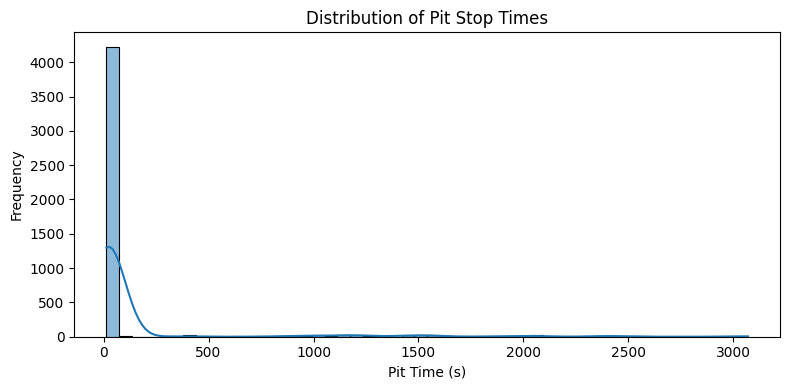

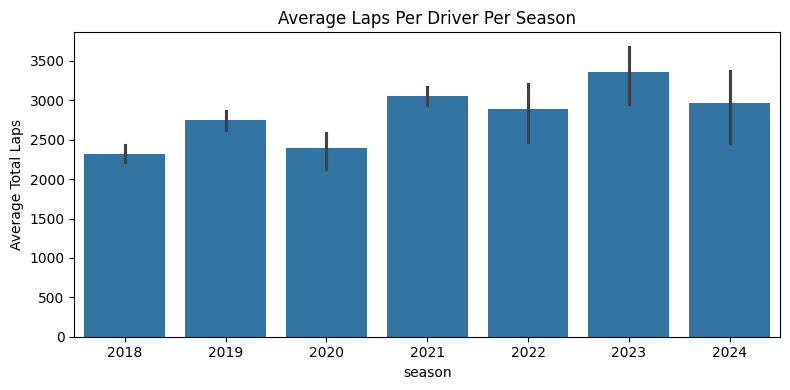

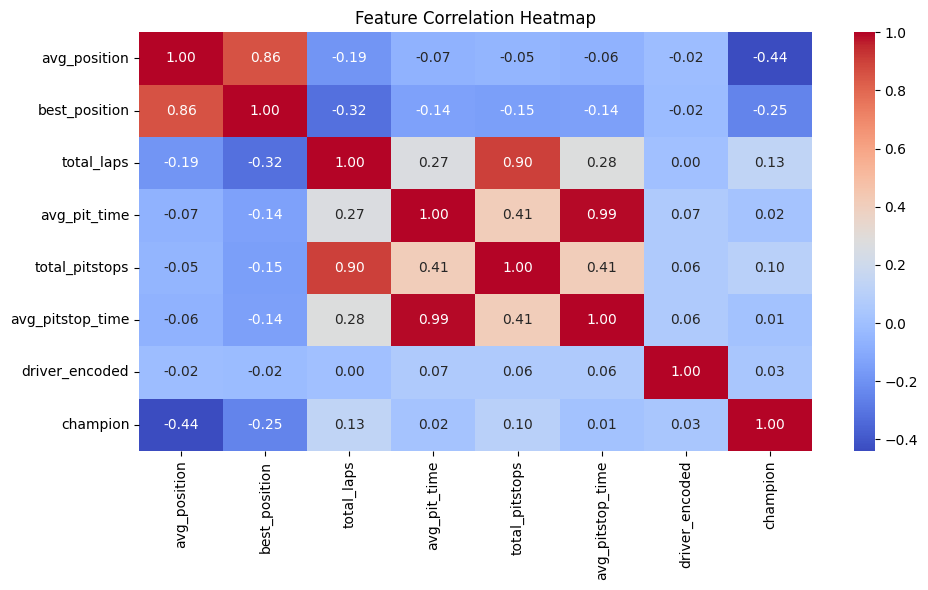

In [11]:
# Visualization: Distribution of pit stop times
plt.figure(figsize=(8, 4))
sns.histplot(df["pit_time"].dropna(), bins=50, kde=True)
plt.title("Distribution of Pit Stop Times")
plt.xlabel("Pit Time (s)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Visualization: Average laps per season
plt.figure(figsize=(8, 4))
sns.barplot(data=agg, x="season", y="total_laps", estimator=np.mean)
plt.title("Average Laps Per Driver Per Season")
plt.ylabel("Average Total Laps")
plt.tight_layout()
plt.show()

# Visualization: Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(agg[features + ["champion"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


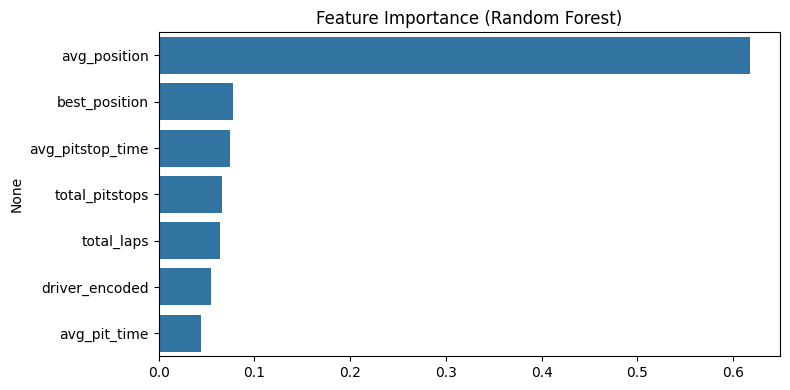

In [12]:
# Feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(agg[features], agg["champion"])
importances = rf_temp.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

# Modeling setup
X = agg[features]
y = agg["champion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results_clean = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results_clean[name] = {
        "accuracy": acc,
        "classification_report": report,
        "model": model
    }


Model Accuracies:
{'Logistic Regression': 0.9773, 'Random Forest': 1.0, 'KNN': 0.9773, 'Naive Bayes': 0.9773}
Best Model: Random Forest


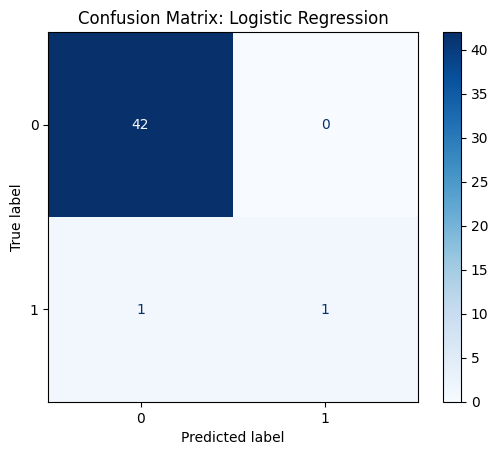

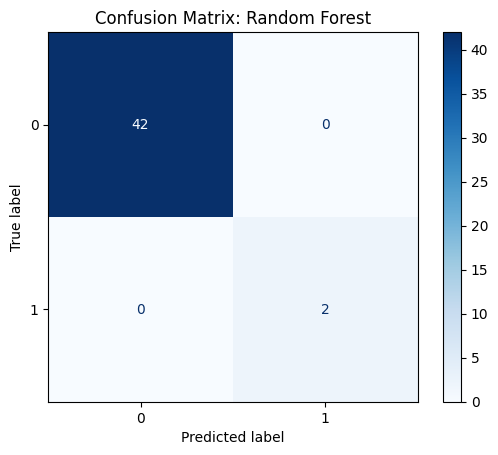

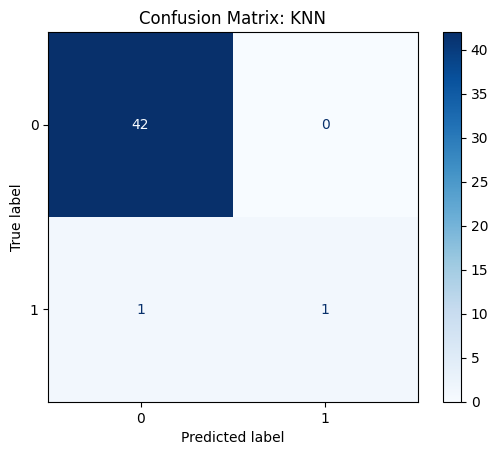

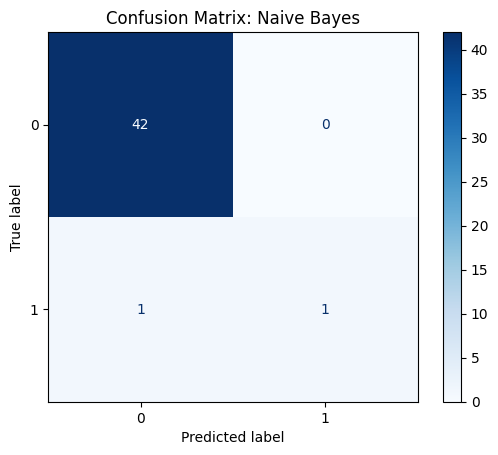

F1 Scores:
Logistic Regression: 0.6667
Random Forest: 1.0000
KNN: 0.6667
Naive Bayes: 0.6667

Predicted 2025 Champion(s):
             driver  avg_position  total_laps  total_pitstops
144  Max Verstappen      3.290323        3646             118


In [13]:
# Accuracy summary
accuracy_summary = {name: round(results_clean[name]["accuracy"], 4) for name in results_clean}
best_model = max(accuracy_summary, key=accuracy_summary.get)
print("Model Accuracies:")
print(accuracy_summary)
print(f"Best Model: {best_model}")

# F1 scores and confusion matrices
f1_scores = {}
for name, result in results_clean.items():
    model = result["model"]
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

print("F1 Scores:")
for name, score in f1_scores.items():
    print(f"{name}: {score:.4f}")

# Predict 2025 Champion using 2024 data
df_2024 = agg[agg["season"] == 2024].copy()
X_2024 = df_2024[features]
X_2024_scaled = scaler.transform(X_2024)

rf_model = results_clean["Random Forest"]["model"]
y_pred_2025 = rf_model.predict(X_2024_scaled)
df_2024["predicted_champion_2025"] = y_pred_2025
predicted_champions = df_2024[df_2024["predicted_champion_2025"] == 1]

print("\nPredicted 2025 Champion(s):")
print(predicted_champions[["driver", "avg_position", "total_laps", "total_pitstops"]])
